In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

DATA_PATH = '/content/drive/MyDrive/ENV dataset'

In [ ]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [ ]:
# Import libraries
import os
import numpy as np
import librosa
import random
from audiomentations import Compose, PitchShift, TimeStretch, Gain, Shift
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
SAMPLE_RATE = 16000
DURATION = 10
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MELS = 128

In [ ]:
# Augmentation
AUGMENT = Compose([
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5)
])

In [ ]:
TARGET_WIDTH = 94  # you want all mel spectrograms to have 94 time frames

def extract_mel_spectrogram(file_path, apply_augment=False):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(audio.shape) > 1:
            audio = librosa.to_mono(audio)
        if len(audio) < SAMPLES_PER_TRACK:
            audio = np.pad(audio, (0, SAMPLES_PER_TRACK - len(audio)))
        else:
            audio = audio[:SAMPLES_PER_TRACK]
        if apply_augment:
            audio = AUGMENT(samples=audio, sample_rate=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # PAD or CROP TIME DIMENSION TO FIXED WIDTH
        if mel_db.shape[1] < TARGET_WIDTH:
            pad_width = TARGET_WIDTH - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :TARGET_WIDTH]

        return mel_db

    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None


def apply_specaugment(mel, time_mask_param=15, freq_mask_param=10):
    m = mel.copy()
    f = random.randint(0, freq_mask_param)
    f0 = random.randint(0, m.shape[0] - f)
    m[f0:f0+f, :] = 0
    t = random.randint(0, time_mask_param)
    t0 = random.randint(0, m.shape[1] - t)
    m[:, t0:t0+t] = 0
    return m

In [ ]:
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []

        for path, label in zip(batch_paths, batch_labels):
            mel = extract_mel_spectrogram(path, apply_augment=self.augment)
            if mel is not None:
                X.append(mel[..., np.newaxis])
                y.append(label)

        if len(X) == 0:
            return self.__getitem__((index + 1) % self.__len__())

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.file_paths, self.labels))
            random.shuffle(zipped)
            self.file_paths, self.labels = zip(*zipped)


In [ ]:
# Prepare data
file_paths = []
labels = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                file_paths.append(os.path.join(folder, file))
                labels.append(label)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels_onehot, test_size=0.2, stratify=labels_encoded, random_state=42
)

train_gen = AudioDataGenerator(train_paths, train_labels, augment=True)
val_gen = AudioDataGenerator(test_paths, test_labels, augment=False)

In [ ]:
# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(labels_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 92, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 92, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,293,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,355 (9.11 MB)

 Trainable params: 2,387,651 (9.11 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Compute class weights
y_train_labels = np.argmax(train_labels, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Train model with callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/ENVMODEL1.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5738 - loss: 1.0414 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 1961s 13s/step - accuracy: 0.5740 - loss: 1.0406 - val_accuracy: 0.5075 - val_loss: 0.9027 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 883s 6s/step - accuracy: 0.6679 - loss: 0.7794 - val_accuracy: 0.4625 - val_loss: 1.3694 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6729 - loss: 0.7416
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 ━━━━━━━━━━━━━━━━━━━━ 827s 6s/step - accuracy: 0.6730 - loss: 0.7414 - val_accuracy: 0.5725 - val_loss: 0.9291 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 876s 6s/step - accuracy: 0.7310 - loss: 0.6212 - val_accuracy: 0.4133 - val_loss: 1.8638 - learning_rate: 5.0000e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7543 - loss: 0.5808
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
150/150 ━━━━━━━━━━━━━━━━━━━━ 833s 6s/step - accuracy: 0.7543 - loss: 0.5808 - val_

150/150 ━━━━━━━━━━━━━━━━━━━━ 839s 6s/step - accuracy: 0.7587 - loss: 0.5518 - val_accuracy: 0.7333 - val_loss: 0.6292 - learning_rate: 2.5000e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 838s 6s/step - accuracy: 0.7849 - loss: 0.5359 - val_accuracy: 0.5467 - val_loss: 1.4822 - learning_rate: 2.5000e-04
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8002 - loss: 0.4912
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
150/150 ━━━━━━━━━━━━━━━━━━━━ 873s 6s/step - accuracy: 0.8001 - loss: 0.4913 - val_accuracy: 0.6483 - val_loss: 0.8849 - learning_rate: 2.5000e-04
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8062 - loss: 0.4844

150/150 ━━━━━━━━━━━━━━━━━━━━ 826s 6s/step - accuracy: 0.8062 - loss: 0.4845 - val_accuracy: 0.7700 - val_loss: 0.5807 - learning_rate: 1.2500e-04
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7960 - loss: 0.4824

150/150 ━━━━━━━━━━━━━━━━━━━━ 895s 6s/step - accuracy: 0.7960 - loss: 0.4824 - val_accuracy: 0.8050 - val_loss: 0.4700 - learning_rate: 1.2500e-04
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 842s 6s/step - accuracy: 0.7938 - loss: 0.4656 - val_accuracy: 0.7817 - val_loss: 0.5216 - learning_rate: 1.2500e-04
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8068 - loss: 0.4475
Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
150/150 ━━━━━━━━━━━━━━━━━━━━ 843s 6s/step - accuracy: 0.8068 - loss: 0.4476 - val_accuracy: 0.7550 - val_loss: 0.6390 - learning_rate: 1.2500e-04
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8090 - loss: 0.4669

150/150 ━━━━━━━━━━━━━━━━━━━━ 822s 5s/step - accuracy: 0.8090 - loss: 0.4668 - val_accuracy: 0.8250 - val_loss: 0.4273 - learning_rate: 6.2500e-05
Epoch 14/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 834s 6s/step - accuracy: 0.8120 - loss: 0.4562 - val_accuracy: 0.8200 - val_loss: 0.4350 - learning_rate: 6.2500e-05
Epoch 15/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8225 - loss: 0.4311
Epoch 15: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
150/150 ━━━━━━━━━━━━━━━━━━━━ 851s 6s/step - accuracy: 0.8224 - loss: 0.4312 - val_accuracy: 0.8308 - val_loss: 0.4378 - learning_rate: 6.2500e-05
Epoch 16/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 835s 5s/step - accuracy: 0.8236 - loss: 0.4264 - val_accuracy: 0.7908 - val_loss: 0.5244 - learning_rate: 3.1250e-05
Epoch 17/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8257 - loss: 0.4222
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
150/150 ━━━━━━━━━━━━━━━━━━━━ 822s 5s/step - accuracy: 0.8257 - lo

In [ ]:
# Load test data for full evaluation
X_test = []
y_test = []

for path, label in zip(test_paths, test_labels):
    mel = extract_mel_spectrogram(path)
    if mel is not None:
        X_test.append(mel[..., np.newaxis])
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("CNN + Mel (Split Dataset) Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step
CNN + Mel (Split Dataset) Classification Report:
              precision    recall  f1-score   support

In Transport       0.93      0.82      0.87       400
      Indoor       0.77      0.86      0.81       400
     Outdoor       0.80      0.79      0.79       400

    accuracy                           0.82      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.82      0.83      1200



38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step


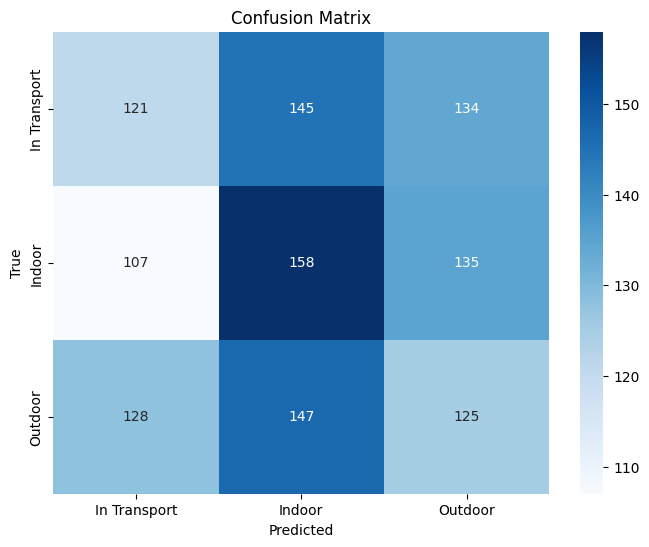

              precision    recall  f1-score   support

In Transport       0.34      0.30      0.32       400
      Indoor       0.35      0.40      0.37       400
     Outdoor       0.32      0.31      0.31       400

    accuracy                           0.34      1200
   macro avg       0.34      0.34      0.34      1200
weighted avg       0.34      0.34      0.34      1200



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_true = np.argmax(test_labels, axis=1)
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = le.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Optional: Detailed report
print(classification_report(y_true, y_pred_classes, target_names=labels))


In [ ]:
!pip install -q tensorflow tensorflow_hub librosa

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 2. LOAD YAMNet MODEL FROM TF HUB ---
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# --- 3. FEATURE EXTRACTION FUNCTION USING YAMNet ---
def extract_yamnet_embedding(file_path):
    try:
        waveform, sr = librosa.load(file_path, sr=16000, duration=10.0)
        if len(waveform) < 160000:
            waveform = np.pad(waveform, (0, 160000 - len(waveform)))
        else:
            waveform = waveform[:160000]

        scores, embeddings, spectrogram = yamnet_model(waveform)
        return np.mean(embeddings.numpy(), axis=0)  # average over time
    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None

# --- 4. LOAD DATASET AND EXTRACT EMBEDDINGS ---
DATA_PATH = "/content/drive/MyDrive/ENV dataset"
file_paths = []
labels = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                file_paths.append(os.path.join(folder, file))
                labels.append(label)

print(f"Found {len(file_paths)} audio files.")

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Extract embeddings
X = []
y = []
for path, label in zip(file_paths, labels_encoded):
    embedding = extract_yamnet_embedding(path)
    if embedding is not None:
        X.append(embedding)
        y.append(label)

X = np.array(X)
y = np.array(y)

# --- 5. TRAIN/TEST SPLIT ---
X_yam_train, X_yam_test, y_yam_train, y_yam_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- 6. TRAIN A SIMPLE CLASSIFIER ---
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])






Found 6000 audio files.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,683 (1.13 MB)

 Trainable params: 295,683 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6965 - loss: 0.7104

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 128, 94, 1), dtype=float32). Expected shape (None, 1024), but input has incompatible shape (None, 128, 94, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 94, 1), dtype=float32)
  • training=False
  • mask=None

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_yam_train, y_yam_train, validation_data=(X_yam_test, y_yam_test), epochs=50,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                        tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/yamnet_classifier.h5", save_best_only=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
                                            ])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,683 (1.13 MB)

 Trainable params: 295,683 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8043 - loss: 0.4446

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8044 - loss: 0.4444 - val_accuracy: 0.8450 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 2/50
144/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8160 - loss: 0.4124

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8165 - loss: 0.4121 - val_accuracy: 0.8442 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8461 - loss: 0.3643

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8461 - loss: 0.3643 - val_accuracy: 0.8467 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 4/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8541 - loss: 0.3442

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8540 - loss: 0.3442 - val_accuracy: 0.8508 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8595 - loss: 0.3239

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8595 - loss: 0.3239 - val_accuracy: 0.8592 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 6/50
146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8649 - loss: 0.3192

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8651 - loss: 0.3190 - val_accuracy: 0.8775 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8835 - loss: 0.2742 - val_accuracy: 0.8492 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8895 - loss: 0.2658

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8894 - loss: 0.2658 - val_accuracy: 0.8775 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8908 - loss: 0.2497 - val_accuracy: 0.8658 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 10/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8993 - loss: 0.2551

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8992 - loss: 0.2552 - val_accuracy: 0.8717 - val_loss: 0.3017 - learning_rate: 0.0010
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9068 - loss: 0.2367 - val_accuracy: 0.8808 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9104 - loss: 0.2197 - val_accuracy: 0.8717 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 13/50
146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9202 - loss: 0.1946

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9203 - loss: 0.1947 - val_accuracy: 0.8875 - val_loss: 0.2964 - learning_rate: 5.0000e-04
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9256 - loss: 0.1840 - val_accuracy: 0.8817 - val_loss: 0.3037 - learning_rate: 5.0000e-04
Epoch 15/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9289 - loss: 0.1766 - val_accuracy: 0.8883 - val_loss: 0.3016 - learning_rate: 5.0000e-04
Epoch 16/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9388 - loss: 0.1612

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9388 - loss: 0.1612 - val_accuracy: 0.8883 - val_loss: 0.2941 - learning_rate: 2.5000e-04
Epoch 17/50
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9411 - loss: 0.1497

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9412 - loss: 0.1497 - val_accuracy: 0.8883 - val_loss: 0.2929 - learning_rate: 2.5000e-04
Epoch 18/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9441 - loss: 0.1405 - val_accuracy: 0.8917 - val_loss: 0.2933 - learning_rate: 2.5000e-04
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9553 - loss: 0.1300 - val_accuracy: 0.8908 - val_loss: 0.2942 - learning_rate: 2.5000e-04
Epoch 20/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9572 - loss: 0.1243 - val_accuracy: 0.8933 - val_loss: 0.2937 - learning_rate: 1.2500e-04
Epoch 21/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9543 - loss: 0.1188 - val_accuracy: 0.8917 - val_loss: 0.3005 - learning_rate: 1.2500e-04
Epoch 22/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9557 - loss: 0.1235 - val_accuracy: 0.8933 - val_loss: 0.2953 - learning_rate: 6.2500e-05


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


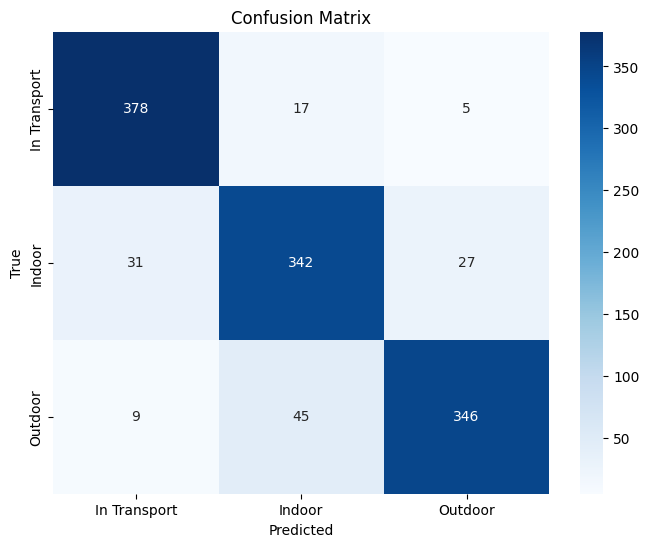

              precision    recall  f1-score   support

In Transport       0.90      0.94      0.92       400
      Indoor       0.85      0.85      0.85       400
     Outdoor       0.92      0.86      0.89       400

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



In [ ]:
y_pred = model.predict(X_yam_test)  # X_test from YAMNet embeddings!

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_yam_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_yam_test, y_pred_classes, target_names=le.classes_))

In [ ]:
# Load test data for full evaluation
X_test = []
y_test = []

for path, label in zip(test_paths, test_labels):
    mel = extract_mel_spectrogram(path)
    if mel is not None:
        X_test.append(mel[..., np.newaxis])
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("CNN + Mel (Split Dataset) Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 128, 94, 1), dtype=float32). Expected shape (None, 1024), but input has incompatible shape (32, 128, 94, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 128, 94, 1), dtype=float32)
  • training=False
  • mask=None